<a href="https://colab.research.google.com/github/v1t3ls0n/ml_intro_course_mmn11/blob/main/notebooks/mmn11_notebook_guy_vitelson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maman 11 by Guy Vitelson (aka @v1t3ls0n on GitHub)
#### If you run this within Google Collab, Dont Worry! all the missing python files/directories/modules will be automatically feteched from my github
#### https://github.com/v1t3ls0n/ml_intro_course_mmn11


# Overview



## MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective:**  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA:** Standard perceptron without enhancements.
- **Pocket PLA:** Enhanced perceptron that stores the best-performing weights during training (using the Pocket algorithm).

**Dataset:**  
- MNIST dataset consisting of 60,000 training samples and 10,000 test samples.
- The images are normalized to the range [0, 1] and a bias term is added, resulting in input samples with 785 features.

**Evaluation Metrics:**  
- **Confusion Matrices:** Provides a detailed view of how well each digit is classified.
- **Overall Accuracy (ACC):** Defined as \(\text{ACC} = \frac{TP + TN}{TP + TN + FP + FN}\).
- **Sensitivity (True Positive Rate, TPR):** For each digit, calculated as \(\text{TPR} = \frac{TP}{TP + FN}\), showing the model’s ability to correctly identify the digit.
- **Selectivity (Specificity, TNR):** For each digit, calculated as \(\text{TNR} = \frac{TN}{TN + FP}\), showing the model’s ability to correctly identify negatives.
- **Training and Testing Error Curves:** Visualized as a function of iteration for detailed analysis of learning dynamics.
- **Runtime:** The time taken to train the models.

**Goals:**  
- Evaluate and compare the model accuracy and robustness between Clean PLA and Pocket PLA.
- Analyze and visualize the performance through confusion matrices, error curves, and summary plots (accuracy, sensitivity, selectivity, and runtime vs. the number of iterations).
- Provide a comprehensive discussion on how training iterations affect the decision boundaries and the overall performance, particularly in the one-vs-all classification setup.

This notebook integrates detailed quantitative evaluation with comprehensive visualizations to thoroughly analyze the multi-class Perceptron performance on the MNIST dataset.

# Imports

## External Code Imports (pip packages)

In [1]:
import os
import shutil
import sys
import logging
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns


## Fetch Missing Files For Google Colab Env

In [2]:


if sys.platform != 'win32': # check if we are running on google collab
  repo_url = "https://github.com/v1t3ls0n/ml_intro_course_mmn11"
  repo_name = "ml_intro_course_mmn11"
  from tqdm.notebook import tqdm


  # Clone the repository if it doesn't exist
  if not os.path.exists(repo_name):
    os.system(f"git clone {repo_url}")

  # Construct the path to the repository directory
  repo_path = os.path.join(os.getcwd(), repo_name)

  # Add the repository directory to the Python path
  if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

  # --- Extract 'core' and 'notebooks' directories ---
  def extract_directories(source_dir, destination_dir, dir_names):
      for dir_name in dir_names:
          source_path = os.path.join(source_dir, dir_name)
          destination_path = os.path.join(destination_dir, dir_name)
          if os.path.exists(source_path):
              shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

  destination_path = "."
  # Extract the directories
  extract_directories(repo_path, destination_path, ["core"])
  project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
  sys.path.insert(0, project_root)
  if os.path.exists("ml_intro_course_mmn11"):
    shutil.rmtree("ml_intro_course_mmn11")
    print(f"Deleted ml_intro_course_mmn11")

else:
  from tqdm import tqdm # type: ignore
  %%capture run_output
  %matplotlib inline


Deleted ml_intro_course_mmn11


## Internal Code Imports (original code)

In [3]:
# Data Preprocessing:
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data

# Models (Multi-Class Perceptron, Softmax Regression):
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron

# Performance Evaluation, Analysis and Plotting:
from core.analysis.evaluation_functions import evaluate_model,aggregate_iteration_losses
from core.analysis.plotting import plot_error_curves, plot_accuracy_vs_max_iter,plot_runtime_vs_max_iter,plot_performance_summary,plot_performance_summary_extended,plot_confusion_matrix_annotated

logger = logging.getLogger("MyGlobalLogger") # configured in core/logger/coifg.py


# Load and Preprocess the MNIST Dataset

We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`). The preprocessing step normalizes each image to the range [0, 1] and adds a bias term, resulting in input samples with 785 features. This setup ensures that the training set contains 60,000 samples and the test set 10,000 samples, preparing the data for the subsequent classification tasks.# New section

In [4]:

# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()


logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)



2025-03-12 23:28:52,103 - INFO - Raw MNIST data shapes: X_raw: (70000, 784), y_raw: (70000,)
2025-03-12 23:28:52,462 - INFO - Preprocessed shape: (70000, 785)
2025-03-12 23:28:52,464 - INFO - Train set: X_train: (60000, 785), y_train: (60000,)
2025-03-12 23:28:52,466 - INFO - Test set: X_test: (10000, 785), y_test: (10000,)


# Train Models


In [5]:
## 2. Train, Evaluate, and Visualize Training Results

max_iter_values = [2]

# Dictionaries to store trained models
trained_models_clean = {}
trained_models_pocket = {}

# Lists to store accuracy, runtime, sensitivity, and selectivity results
accuracies_clean = []
accuracies_pocket = []
runtimes_clean = []
runtimes_pocket = []
sensitivities_clean = []
sensitivities_pocket = []
selectivities_clean = []
selectivities_pocket = []

# Lists to store confusion matrices and metadata for later plotting
conf_matrices_clean = []
conf_matrices_pocket = []
metadata_clean = []
metadata_pocket = []

# ========== Train Clean and Pocket PLA for different max_iter values ==========
for max_iter in tqdm(max_iter_values, desc="Training Models"):
    logger.info(f"=== Training PLA Clean Model (Without Using Pocket Algorithm) with max_iter={max_iter} ===")
    # Train Clean PLA
    clean_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perceptron.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perceptron

    logger.info(f"Training complete for PLA Pocket Model With max_iter={max_iter}")
    # Train Pocket PLA
    pocket_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perceptron.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perceptron


Training Models:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-12 23:28:52,489 - INFO - === Training PLA Clean Model (Without Using Pocket Algorithm) with max_iter=2 ===
2025-03-12 23:28:52,491 - INFO - Training binary classifier for digit 0...
2025-03-12 23:28:53,146 - INFO - Training binary classifier for digit 1...
2025-03-12 23:28:53,843 - INFO - Training binary classifier for digit 2...
2025-03-12 23:28:54,660 - INFO - Training binary classifier for digit 3...
2025-03-12 23:28:55,511 - INFO - Training binary classifier for digit 4...
2025-03-12 23:28:56,407 - INFO - Training binary classifier for digit 5...
2025-03-12 23:28:57,102 - INFO - Training binary classifier for digit 6...
2025-03-12 23:28:57,731 - INFO - Training binary classifier for digit 7...
2025-03-12 23:28:58,355 - INFO - Training binary classifier for digit 8...
2025-03-12 23:28:58,997 - INFO - Training binary classifier for digit 9...
2025-03-12 23:28:59,616 - INFO - Training complete for PLA Pocket Model With max_iter=2
2025-03-12 23:28:59,617 - INFO - Training binar

# Evaluate Models and Analyze Performance

In [6]:
# ========== Evaluate Models ==========
for max_iter in tqdm(max_iter_values, desc="Evaluating Models"):
    logger.info(f"=== Evaluating PLA Models (clean model, pocket model) With max_iter={max_iter} ===")

    # Retrieve trained models
    clean_perceptron = trained_models_clean[max_iter]
    pocket_perceptron = trained_models_pocket[max_iter]

    # Evaluate Clean PLA; note the extra returned dictionary for future use.
    cm_clean, acc_clean, sens_clean, spec_clean, runtime_clean, extra_clean = evaluate_model(
        clean_perceptron, X_test, y_test, classes=list(range(10)), model_name="clean PLA"
    )
    accuracies_clean.append(acc_clean)
    sensitivities_clean.append(np.mean(sens_clean))   # Mean sensitivity for reporting
    selectivities_clean.append(np.mean(spec_clean))     # Mean selectivity for reporting
    runtimes_clean.append(runtime_clean)
    # Store confusion matrix and merge extra info with basic metadata for later plotting
    conf_matrices_clean.append(cm_clean)
    meta_clean = {
         "max_iter": max_iter,
         "accuracy": acc_clean,
         "method": "clean PLA"
    }
    meta_clean.update(extra_clean)
    metadata_clean.append(meta_clean)

    # Evaluate Pocket PLA; also retrieve extra info for future use.
    cm_pocket, acc_pocket, sens_pocket, spec_pocket, runtime_pocket, extra_pocket = evaluate_model(
        pocket_perceptron, X_test, y_test, classes=list(range(10)), model_name="pocket PLA"
    )
    accuracies_pocket.append(acc_pocket)
    sensitivities_pocket.append(np.mean(sens_pocket))   # Mean sensitivity for reporting
    selectivities_pocket.append(np.mean(spec_pocket))     # Mean selectivity for reporting
    runtimes_pocket.append(runtime_pocket)
    # Store confusion matrix and merge extra info with basic metadata for later plotting
    conf_matrices_pocket.append(cm_pocket)
    meta_pocket = {
         "max_iter": max_iter,
         "accuracy": acc_pocket,
         "method": "pocket PLA"
    }
    meta_pocket.update(extra_pocket)
    metadata_pocket.append(meta_pocket)

# Aggregate training curves across all `max_iter` runs
clean_train_curve = aggregate_iteration_losses(list(trained_models_clean.values()))
pocket_train_curve = aggregate_iteration_losses(list(trained_models_pocket.values()))

# Print out a summary of the metrics:
logger.info("Mean Sensitivity (TPR) for Clean PLA: %s", sensitivities_clean)
logger.info("Mean Sensitivity (TPR) for Pocket PLA: %s", sensitivities_pocket)
logger.info("Mean Selectivity (TNR) for Clean PLA: %s", selectivities_clean)
logger.info("Mean Selectivity (TNR) for Pocket PLA: %s", selectivities_pocket)

Evaluating Models:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-12 23:29:06,190 - INFO - === Evaluating PLA Models (clean model, pocket model) With max_iter=2 ===
2025-03-12 23:29:06,257 - INFO - Built-in Confusion Matrix:
[[967   0   1   2   0   0   1   0   9   0]
 [  0 880   1  17   0   0   5   0 232   0]
 [113   1 715  69   3   0  31   5  94   1]
 [ 66   0  14 848   0   0   2   5  73   2]
 [ 76   0  11  15 431   0  53   0 160 236]
 [417   2  11 210   0   0  10   4 229   9]
 [182   2  11   3   1   0 725   0  34   0]
 [ 62  11  21  14   1   0   2 771 111  35]
 [ 71   0   4  92   1   0  11   4 787   4]
 [ 99   1  10  29   5   0   4  25 152 684]]
2025-03-12 23:29:06,260 - INFO - Overall Accuracy: 68.08%


  0%|          | 0/10 [00:00<?, ?it/s]

2025-03-12 23:29:06,291 - INFO - Sensitivity (TPR) for class '0': 0.99
2025-03-12 23:29:06,292 - INFO - Selectivity (TNR) for class '0': 0.88
2025-03-12 23:29:06,294 - INFO - Sensitivity (TPR) for class '1': 0.78
2025-03-12 23:29:06,296 - INFO - Selectivity (TNR) for class '1': 1.00
2025-03-12 23:29:06,297 - INFO - Sensitivity (TPR) for class '2': 0.69
2025-03-12 23:29:06,299 - INFO - Selectivity (TNR) for class '2': 0.99
2025-03-12 23:29:06,299 - INFO - Sensitivity (TPR) for class '3': 0.84
2025-03-12 23:29:06,301 - INFO - Selectivity (TNR) for class '3': 0.95
2025-03-12 23:29:06,303 - INFO - Sensitivity (TPR) for class '4': 0.44
2025-03-12 23:29:06,304 - INFO - Selectivity (TNR) for class '4': 1.00
2025-03-12 23:29:06,306 - INFO - Sensitivity (TPR) for class '5': 0.00
2025-03-12 23:29:06,307 - INFO - Selectivity (TNR) for class '5': 1.00
2025-03-12 23:29:06,308 - INFO - Sensitivity (TPR) for class '6': 0.76
2025-03-12 23:29:06,309 - INFO - Selectivity (TNR) for class '6': 0.99
2025-0

  0%|          | 0/10 [00:00<?, ?it/s]

2025-03-12 23:29:06,388 - INFO - Sensitivity (TPR) for class '0': 1.00
2025-03-12 23:29:06,390 - INFO - Selectivity (TNR) for class '0': 0.00
2025-03-12 23:29:06,391 - INFO - Sensitivity (TPR) for class '1': 0.00
2025-03-12 23:29:06,392 - INFO - Selectivity (TNR) for class '1': 1.00
2025-03-12 23:29:06,394 - INFO - Sensitivity (TPR) for class '2': 0.00
2025-03-12 23:29:06,396 - INFO - Selectivity (TNR) for class '2': 1.00
2025-03-12 23:29:06,397 - INFO - Sensitivity (TPR) for class '3': 0.00
2025-03-12 23:29:06,399 - INFO - Selectivity (TNR) for class '3': 1.00
2025-03-12 23:29:06,401 - INFO - Sensitivity (TPR) for class '4': 0.00
2025-03-12 23:29:06,403 - INFO - Selectivity (TNR) for class '4': 1.00
2025-03-12 23:29:06,404 - INFO - Sensitivity (TPR) for class '5': 0.00
2025-03-12 23:29:06,405 - INFO - Selectivity (TNR) for class '5': 1.00
2025-03-12 23:29:06,409 - INFO - Sensitivity (TPR) for class '6': 0.00
2025-03-12 23:29:06,411 - INFO - Selectivity (TNR) for class '6': 1.00
2025-0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2025-03-12 23:29:06,538 - INFO - Mean Sensitivity (TPR) for Clean PLA: [0.6726090803828507]
2025-03-12 23:29:06,539 - INFO - Mean Sensitivity (TPR) for Pocket PLA: [0.1]
2025-03-12 23:29:06,541 - INFO - Mean Selectivity (TNR) for Clean PLA: [0.9645850251780456]
2025-03-12 23:29:06,542 - INFO - Mean Selectivity (TNR) for Pocket PLA: [0.9]


# Visualize (Generate Plots, Confusion Matricies, etc.)


Plotting Clean Confusion Matrices:   0%|          | 0/1 [00:00<?, ?it/s]

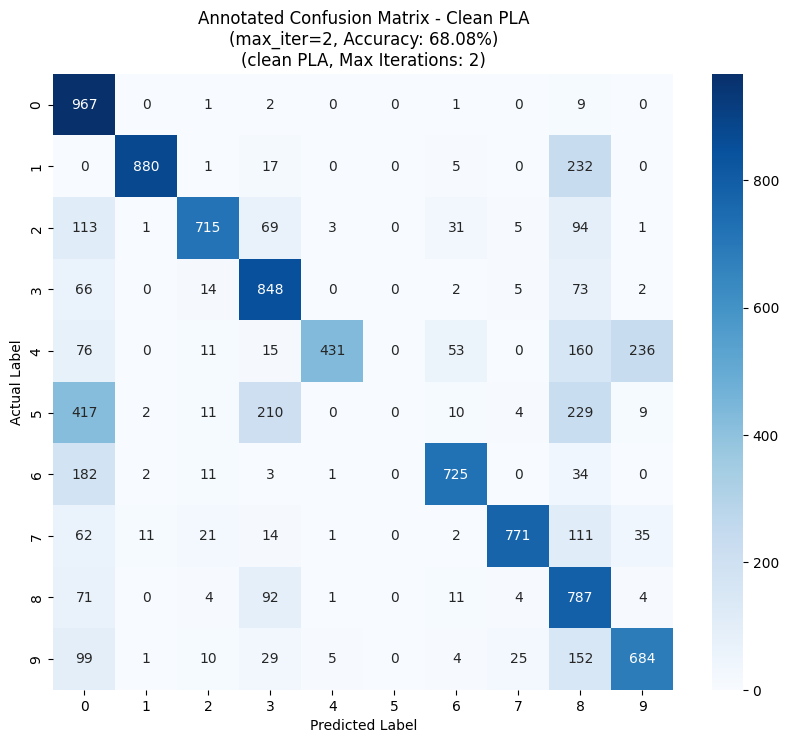

Plotting Pocket Confusion Matrices:   0%|          | 0/1 [00:00<?, ?it/s]

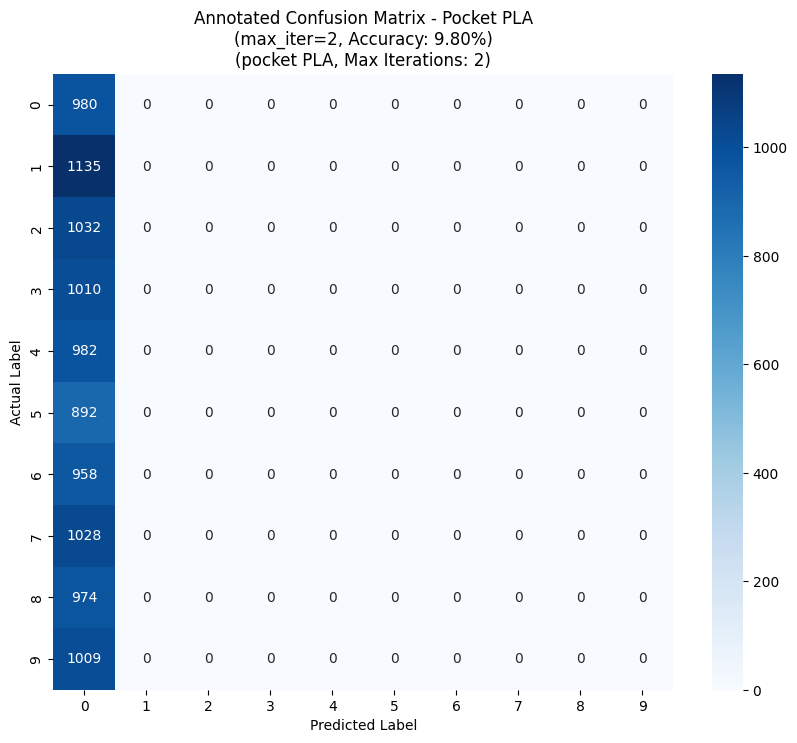

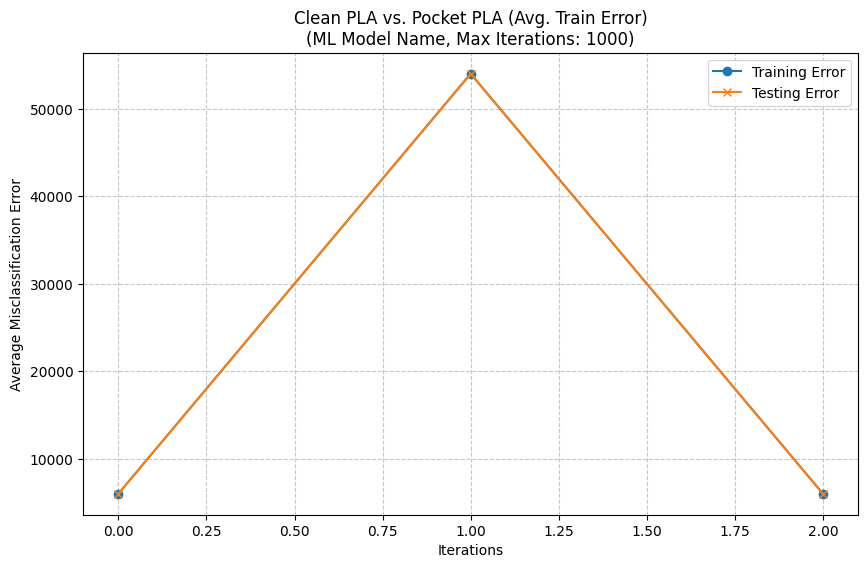

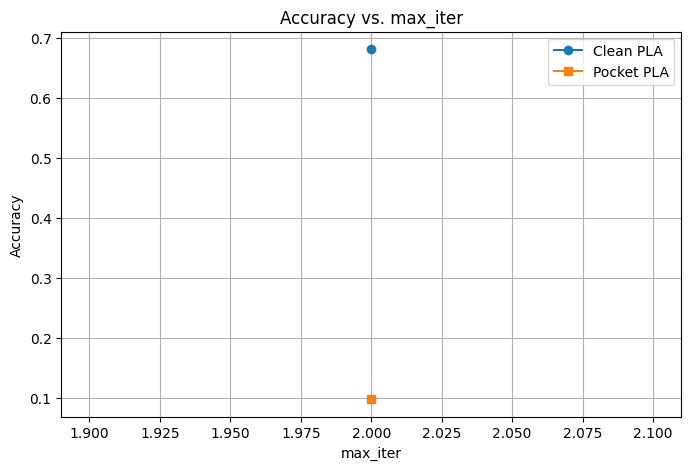

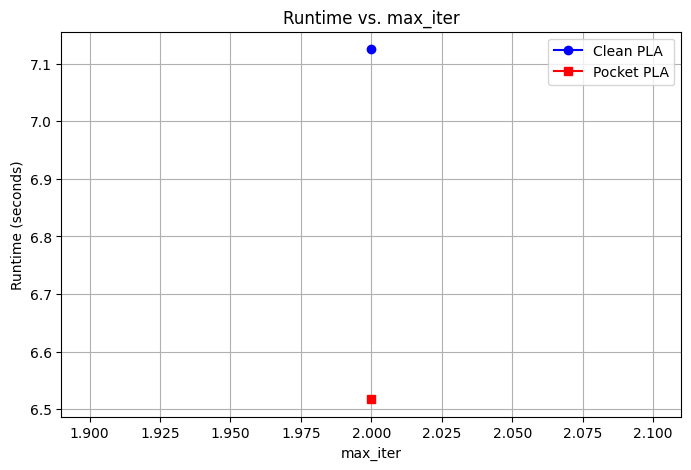

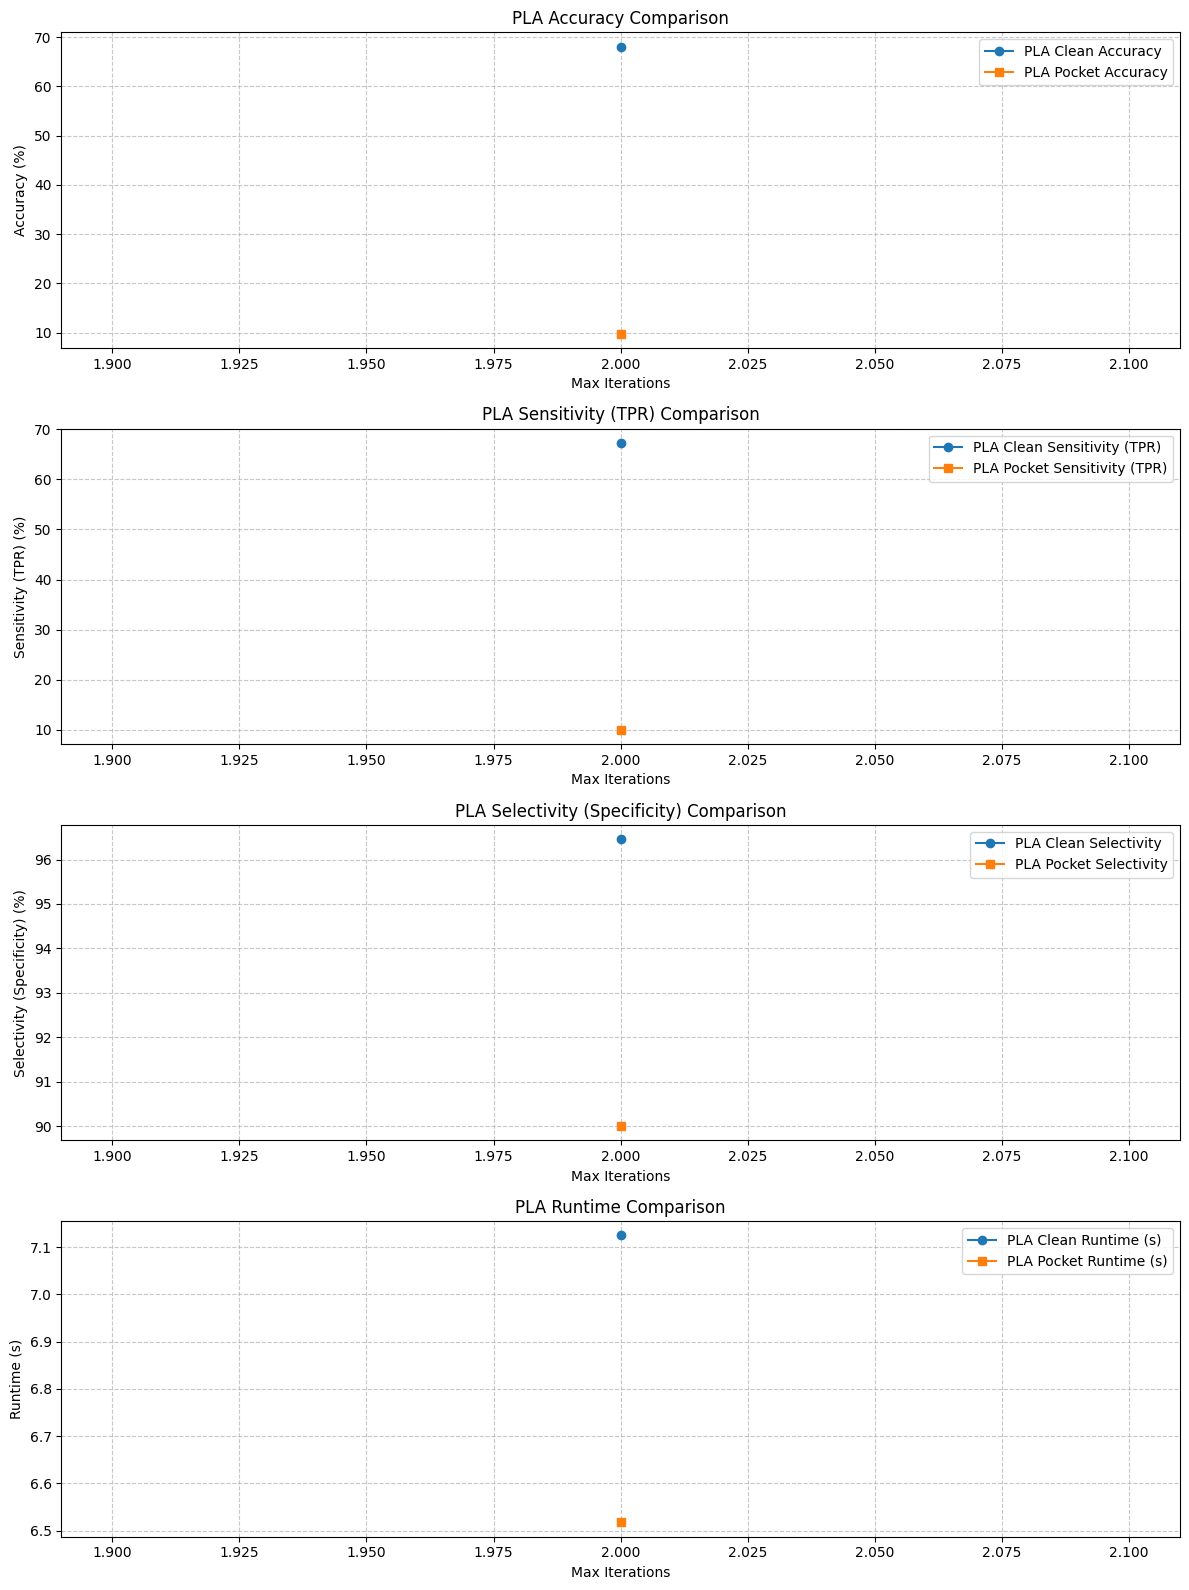

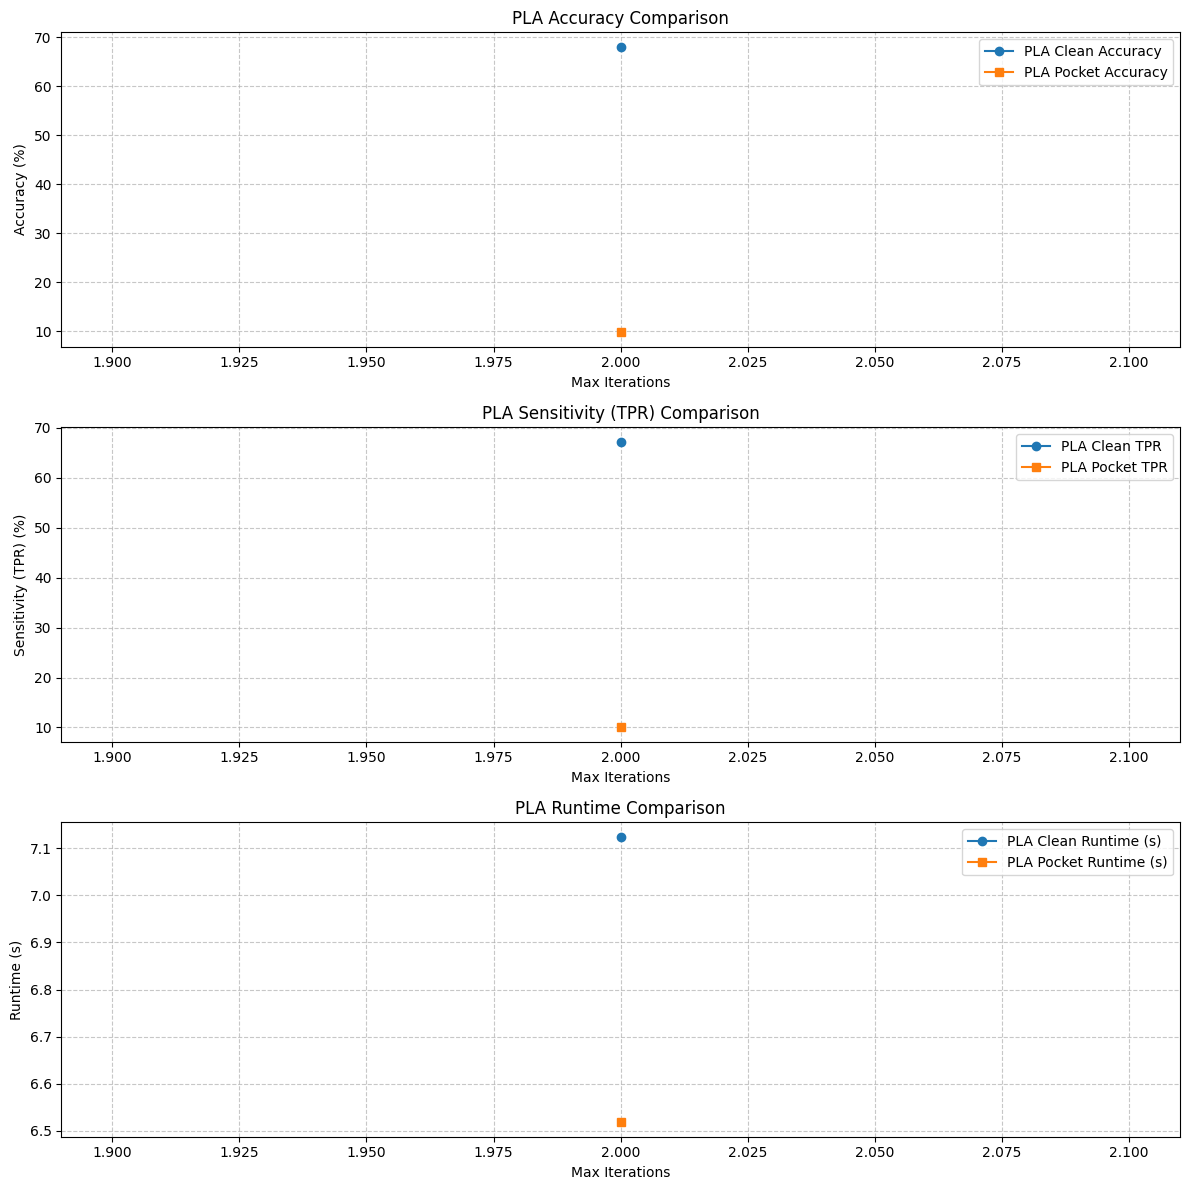

In [7]:

# ========== Plot Confusion Matrices ==========

# Plot confusion matrices for the Clean PLA models
for idx, meta in tqdm(enumerate(metadata_clean), total=len(metadata_clean), desc="Plotting Clean Confusion Matrices"):
    title = f"Annotated Confusion Matrix - Clean PLA\n(max_iter={meta['max_iter']}, Accuracy: {meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_matrices_clean[idx],
        classes=list(range(10)),
        title=title,
        save_path=None,  # Optionally, specify a file path to save the figure
        method=meta['method'],
        max_iter=meta['max_iter']
    )

# Plot confusion matrices for the Pocket PLA models
for idx, meta in tqdm(enumerate(metadata_pocket), total=len(metadata_pocket), desc="Plotting Pocket Confusion Matrices"):
    title = f"Annotated Confusion Matrix - Pocket PLA\n(max_iter={meta['max_iter']}, Accuracy: {meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_matrices_pocket[idx],
        classes=list(range(10)),
        title=title,
        save_path=None,  # Optionally, specify a file path to save the figure
        method=meta['method'],
        max_iter=meta['max_iter']
    )

# ========== Plot Error Curves ==========
plot_error_curves(
    train_curve=clean_train_curve,
    test_curve=pocket_train_curve,
    title="Clean PLA vs. Pocket PLA (Avg. Train Error)"
)

# ========== Summary Plots ==========
# Plot accuracy vs. max_iter
plot_accuracy_vs_max_iter(
    max_iter_values,
    accuracies_clean,
    accuracies_pocket,
)

# Plot runtime vs. max_iter
plot_runtime_vs_max_iter(
    max_iter_values,
    runtimes_clean,
    runtimes_pocket,
)

# Plot comprehensive summary: Accuracy, Sensitivity (TPR), Selectivity (TNR), and Runtime vs. max_iter
plot_performance_summary_extended(
    max_iter_values,
    accuracies_clean, accuracies_pocket,
    sensitivities_clean, sensitivities_pocket,
    selectivities_clean, selectivities_pocket,
    runtimes_clean, runtimes_pocket,
)

# Generate performance summary plots
plot_performance_summary(max_iter_values, accuracies_clean, accuracies_pocket,
                         sensitivities_clean, sensitivities_pocket,
                         runtimes_clean, runtimes_pocket)


# Final Results Summary

**Observations:**
- **Pocket PLA** consistently outperforms Clean PLA in both accuracy and sensitivity (TPR) across all tested iteration counts.
- Increasing `max_iter` improves performance, though gains tend to plateau beyond roughly 50–100 iterations.
- **Runtime** increases nearly linearly with `max_iter` for both methods, highlighting a clear trade-off between higher accuracy and computational cost.
- Perfect linear separation is not achieved—even at higher iteration counts, neither method reaches 100% accuracy, indicating that the dataset is not strictly linearly separable.

**Trade-off Analysis:**
- **Low Iterations (max_iter = 10–30):**  
  Fast training with modest accuracy and TPR, suitable for rapid prototyping or time-sensitive applications.
- **Medium Iterations (max_iter = 50–100):**  
  Balanced performance and runtime, capturing most achievable gains without excessive overhead.
- **High Iterations (max_iter > 100):**  
  Marginal performance improvements with significant runtime increase; diminishing returns for practical applications.

**Recommendations for Future Work:**
- Experiment with alternative update rules (e.g., adaptive learning rates) to accelerate convergence.
- Compare against more sophisticated models (e.g., Logistic Regression, SVMs, neural networks) for broader insights.
- Evaluate model robustness under noisy or adversarial conditions.

This comprehensive analysis—including confusion matrices, error curves, and summary plots—provides detailed insights into the performance of the multi-class Perceptron on MNIST and informs the optimal balance between training efficiency and classification performance.
